#### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import locale

# Data Overview

In [2]:
file_path = 'health_data.csv'
df = pd.read_csv(file_path)

file_path2 = 'model_lasso_predictors.csv'
df_results = pd.read_csv(file_path2)

In [3]:
#missing data
missing_data = df_results.isnull().sum()

columns_missing_data = missing_data[missing_data > 0].index

for column in columns_missing_data:
    print(column)
    print(df[column].isnull().sum()) 

In [4]:
#duplicates 
duplicate_rows = df_results.duplicated()
duplicated_df = df_results[duplicate_rows]

print(duplicated_df)
total_duplicate_rows = duplicate_rows.sum()
print("Total number of duplicate rows:", total_duplicate_rows)
print("Total number of rows:", df.shape[0]) 

Empty DataFrame
Columns: [index, dem_race_black, risk_score_t, gagne_sum_t, cost_t, cost_avoidable_t, program_enrolled_t, log_cost_t_hat, gagne_sum_t_hat, log_cost_avoidable_t_hat, risk_score_t_percentile]
Index: []
Total number of duplicate rows: 0
Total number of rows: 48784


# Chronic Illnesses Case VS Risk Score

In [30]:
#data manipulation
amount_gagne_b = df_results.groupby(['dem_race_black'])['gagne_sum_t']
actual_gagne_grouped = df_results.groupby(['risk_score_t_percentile', 'dem_race_black'])['gagne_sum_t'].mean().reset_index()
predicted_gagne_grouped = df_results.groupby(['risk_score_t_percentile', 'dem_race_black'])['gagne_sum_t_hat'].mean().reset_index()

In [6]:
# labels for the plot
titlename = ' Number of Chronic Illnesses versus Algorithm-predicted Risk, by Race'
groupbycolorname = 'Race'
xname = 'Percentile of Algorithm Risk Score'
yname = 'Number of Active Chronic Conditions'
color_scheme = ["#ffa600", "#764885"]
linetype_scheme = ['-', '--']
group_label = ["White", "Black"]

default_in_percentile = 97
additional_screen_percentile = 55

### Recreation of Obermeyer Plot - Chronic illness case

C:\Users\mana2\AppData\Local\Temp\ipykernel_27132\1950635060.py:6: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


Text(55, 6, 'Referred for screen')

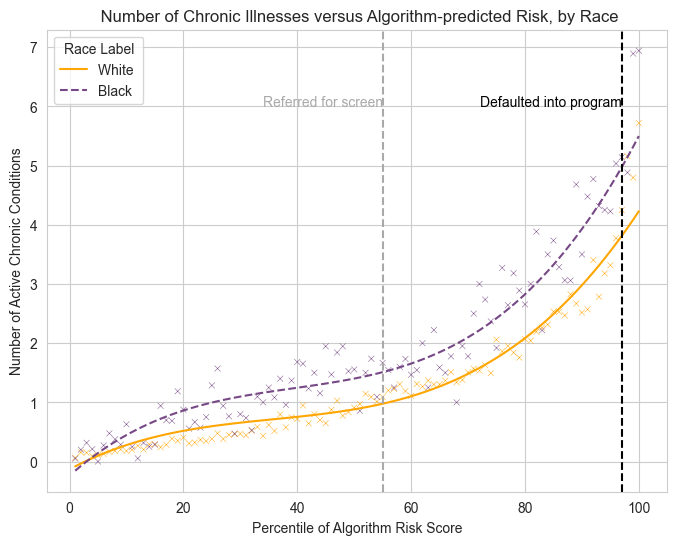

In [7]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
race_mapping = {"White": 0, "Black": 1}

#Actual points
sns.scatterplot(
    data=actual_gagne_grouped,
    x='risk_score_t_percentile',
    y='gagne_sum_t',
    hue='dem_race_black',
    style='dem_race_black',
    palette=color_scheme,
    markers=['x'],
    s=18,
    alpha=1,
    legend=False
)

#smoothing
for race_label, linestyle in zip(group_label, linetype_scheme):
    race_int = race_mapping[race_label]
    race_predicted_data = predicted_gagne_grouped[predicted_gagne_grouped['dem_race_black'] == race_int]

    X_smooth = race_predicted_data['risk_score_t_percentile']
    y_smooth = race_predicted_data['gagne_sum_t_hat']
    
    if race_int == 0:
        degree = 3  
    else:
        degree = 3
    p = np.polyfit(X_smooth, y_smooth, degree)
    y_poly = np.polyval(p, X_smooth)

    sns.lineplot(x=X_smooth, y=y_poly, linestyle=linestyle, color=color_scheme[race_int], label=f'{race_label} ')

    df_results.loc[race_predicted_data.index, f'{race_label}_smoothed_gagne_sum_t'] = y_poly

plt.xlabel(xname)
plt.ylabel(yname)
plt.title(titlename)
legend = plt.legend()
legend.set_title('Race Label')

plt.axvline(x=default_in_percentile, color='black', linestyle='--')
plt.text(default_in_percentile, 6, 'Defaulted into program', color='black', ha='right')
plt.axvline(x=additional_screen_percentile, color='darkgray', linestyle='--')
plt.text(additional_screen_percentile, 6, 'Referred for screen', color='darkgray', ha='right')


### Residuals plot

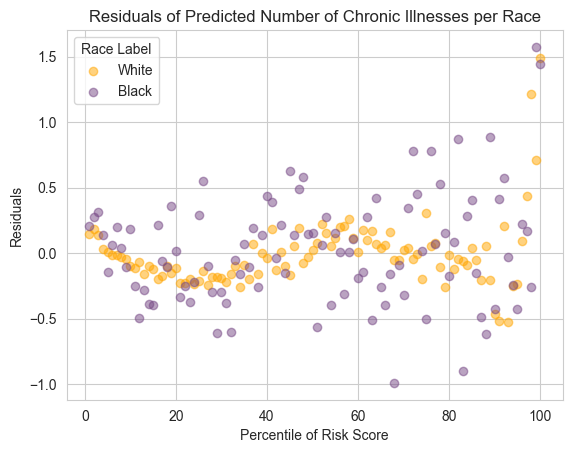

In [8]:
sns.set_style("whitegrid")
for race_label in group_label:
    race_int = race_mapping[race_label]
    race_predicted_data = df_results[df_results['dem_race_black'] == race_int]
    
    #calculate signed residuals per race
    if race_int == 1:
        illness_black = df_results['Black_smoothed_gagne_sum_t'].dropna()
        residuals = actual_gagne_grouped['gagne_sum_t'] - illness_black
    else:
        illness_white = df_results['White_smoothed_gagne_sum_t'].dropna()
        residuals = actual_gagne_grouped['gagne_sum_t'] - illness_white

    df_results.loc[actual_gagne_grouped.index, f'{race_label}_residuals'] = residuals
    plt.scatter(actual_gagne_grouped['risk_score_t_percentile'], residuals, alpha=0.5, color = color_scheme[race_int], label = race_label)

plt.title('Residuals of Predicted Number of Chronic Illnesses per Race')
plt.xlabel('Percentile of Risk Score')
plt.ylabel('Residuals')
legend = plt.legend()
legend.set_title('Race Label')
    

## Polynomial Regression - Chronic Illnes case

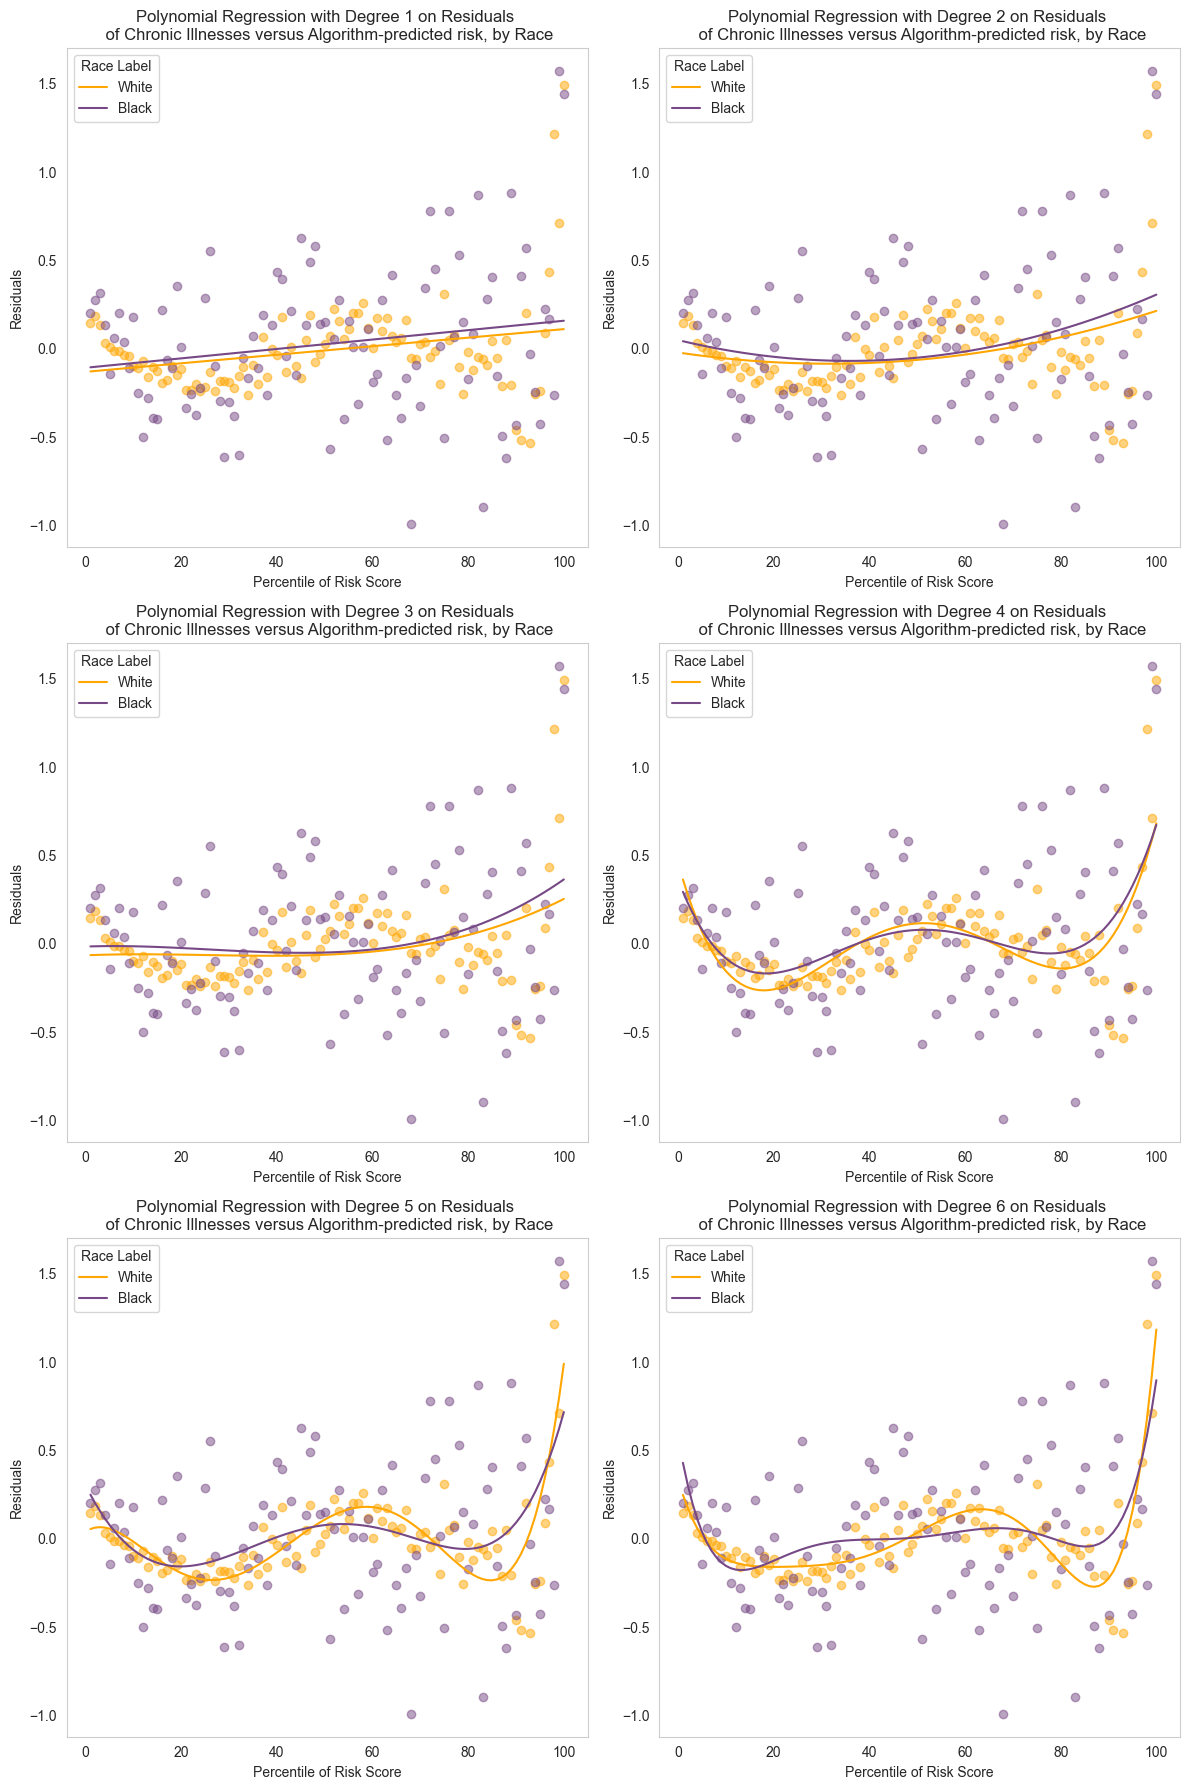

In [9]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()
coefficients_chronic = {}
p_values_chronic = {}
mse_dict_chronic = {}
deviance_dict_chronic = {}

for i, degree in enumerate(range(1, 7)):
    for race_label in group_label:
        race_int = race_mapping[race_label]
        race_predicted_data = actual_gagne_grouped[actual_gagne_grouped['dem_race_black'] == race_int]
        ax = axes[i]

        #signed residuals
        if race_int == 1:
            residuals = df_results['Black_residuals'].dropna()
        else:
            residuals = df_results['White_residuals'].dropna()

        #polynomial regression
        percentiles_re = race_predicted_data['risk_score_t_percentile'].values.reshape(-1, 1)

        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        v_poly = poly_features.fit_transform(percentiles_re)
        v_poly = sm.add_constant(v_poly)

        model = sm.OLS(residuals, v_poly).fit()

        #stores deviance, coefficients, p-values, and mse
        log_likelihood_current = model.llf
        deviance_current = -2 * log_likelihood_current
        deviance_dict_chronic[(race_label, degree)] = deviance_current

        coefficients = model.params
        p_values = model.pvalues
        coefficients_chronic[(race_label, degree)] = coefficients
        p_values_chronic[(race_label, degree)] = p_values
        mse = model.mse_resid
        mse_dict_chronic[(race_label, degree)] = mse

        #plotting
        x_line = np.linspace(percentiles_re.min(), percentiles_re.max(), 100).reshape(-1, 1)
        x_line_poly = poly_features.transform(x_line)
        x_line_poly = sm.add_constant(x_line_poly)
        y_pred = model.predict(x_line_poly)


        ax.scatter(percentiles_re, residuals, alpha=0.5, color=color_scheme[race_int])
        ax.plot(x_line, y_pred, color=color_scheme[race_int], label=f'{race_label}')
        ax.grid(False)
        ax.set_title('Polynomial Regression with Degree {Degree} on Residuals \n of Chronic Illnesses versus Algorithm-predicted risk, by Race'.format(Degree=degree))
        ax.set_ylabel('Residuals')
        ax.set_xlabel('Percentile of Risk Score')
        legend = ax.legend()
        legend.set_title('Race Label')

plt.tight_layout()

In [10]:
#prints coefficients, p-values, and mse
for (race_label, degree), coefficients in coefficients_chronic.items():
  p_values = p_values_chronic[(race_label, degree)]
  mse = mse_dict_chronic[(race_label, degree)]  
  print(f"Race Label: {race_label}, Degree: {degree}")
  print(f"Coefficients: {coefficients}")
  print(f"P-values: {p_values}")
  print(f"MSE: {mse}")
  print("-" * 20)  

Race Label: White, Degree: 1
Coefficients: const   -0.129759
x1       0.002415
dtype: float64
P-values: const    0.014810
x1       0.008493
dtype: float64
MSE: 0.06737130337459392
--------------------
Race Label: Black, Degree: 1
Coefficients: const   -0.106733
x1       0.002659
dtype: float64
P-values: const    0.214243
x1       0.073086
dtype: float64
MSE: 0.17952430220647092
--------------------
Race Label: White, Degree: 2
Coefficients: const   -0.020309
x1      -0.004023
x2       0.000064
dtype: float64
P-values: const    0.796366
x1       0.264815
x2       0.066978
dtype: float64
MSE: 0.0657397534762521
--------------------
Race Label: Black, Degree: 2
Coefficients: const    0.049906
x1      -0.006555
x2       0.000091
dtype: float64
P-values: const    0.698902
x1       0.267646
x2       0.108992
dtype: float64
MSE: 0.1766107830310948
--------------------
Race Label: White, Degree: 3
Coefficients: const   -6.460543e-02
x1       1.112679e-03
x2      -6.274499e-05
x3       8.349162

In [11]:
#prints deviance and change in deviance with respect to degree 1
for (race_label, degree), deviance_current in deviance_dict_chronic.items():
    deviance_degree_1 = deviance_dict_chronic[(race_label, 1)]
    change_in_deviance = deviance_current - deviance_degree_1
    print(f"Race Label: {race_label}, Degree: {degree}")
    print(f"Deviance: {deviance_current}")
    print(f"Change in Deviance with respect to degree 1: {change_in_deviance}")
    print("-" * 20)

Race Label: White, Degree: 1
Deviance: 12.013824140831133
Change in Deviance with respect to degree 1: 0.0
--------------------
Race Label: Black, Degree: 1
Deviance: 110.02296672107346
Change in Deviance with respect to degree 1: 0.0
--------------------
Race Label: White, Degree: 2
Deviance: 8.53663981905882
Change in Deviance with respect to degree 1: -3.477184321772313
--------------------
Race Label: Black, Degree: 2
Deviance: 107.36109253145523
Change in Deviance with respect to degree 1: -2.6618741896182314
--------------------
Race Label: White, Degree: 3
Deviance: 8.146007978232404
Change in Deviance with respect to degree 1: -3.8678161625987286
--------------------
Race Label: Black, Degree: 3
Deviance: 107.04738654646786
Change in Deviance with respect to degree 1: -2.9755801746055965
--------------------
Race Label: White, Degree: 4
Deviance: -41.50300069346403
Change in Deviance with respect to degree 1: -53.516824834295164
--------------------
Race Label: Black, Degree: 4

## Absolute Residuals Poly

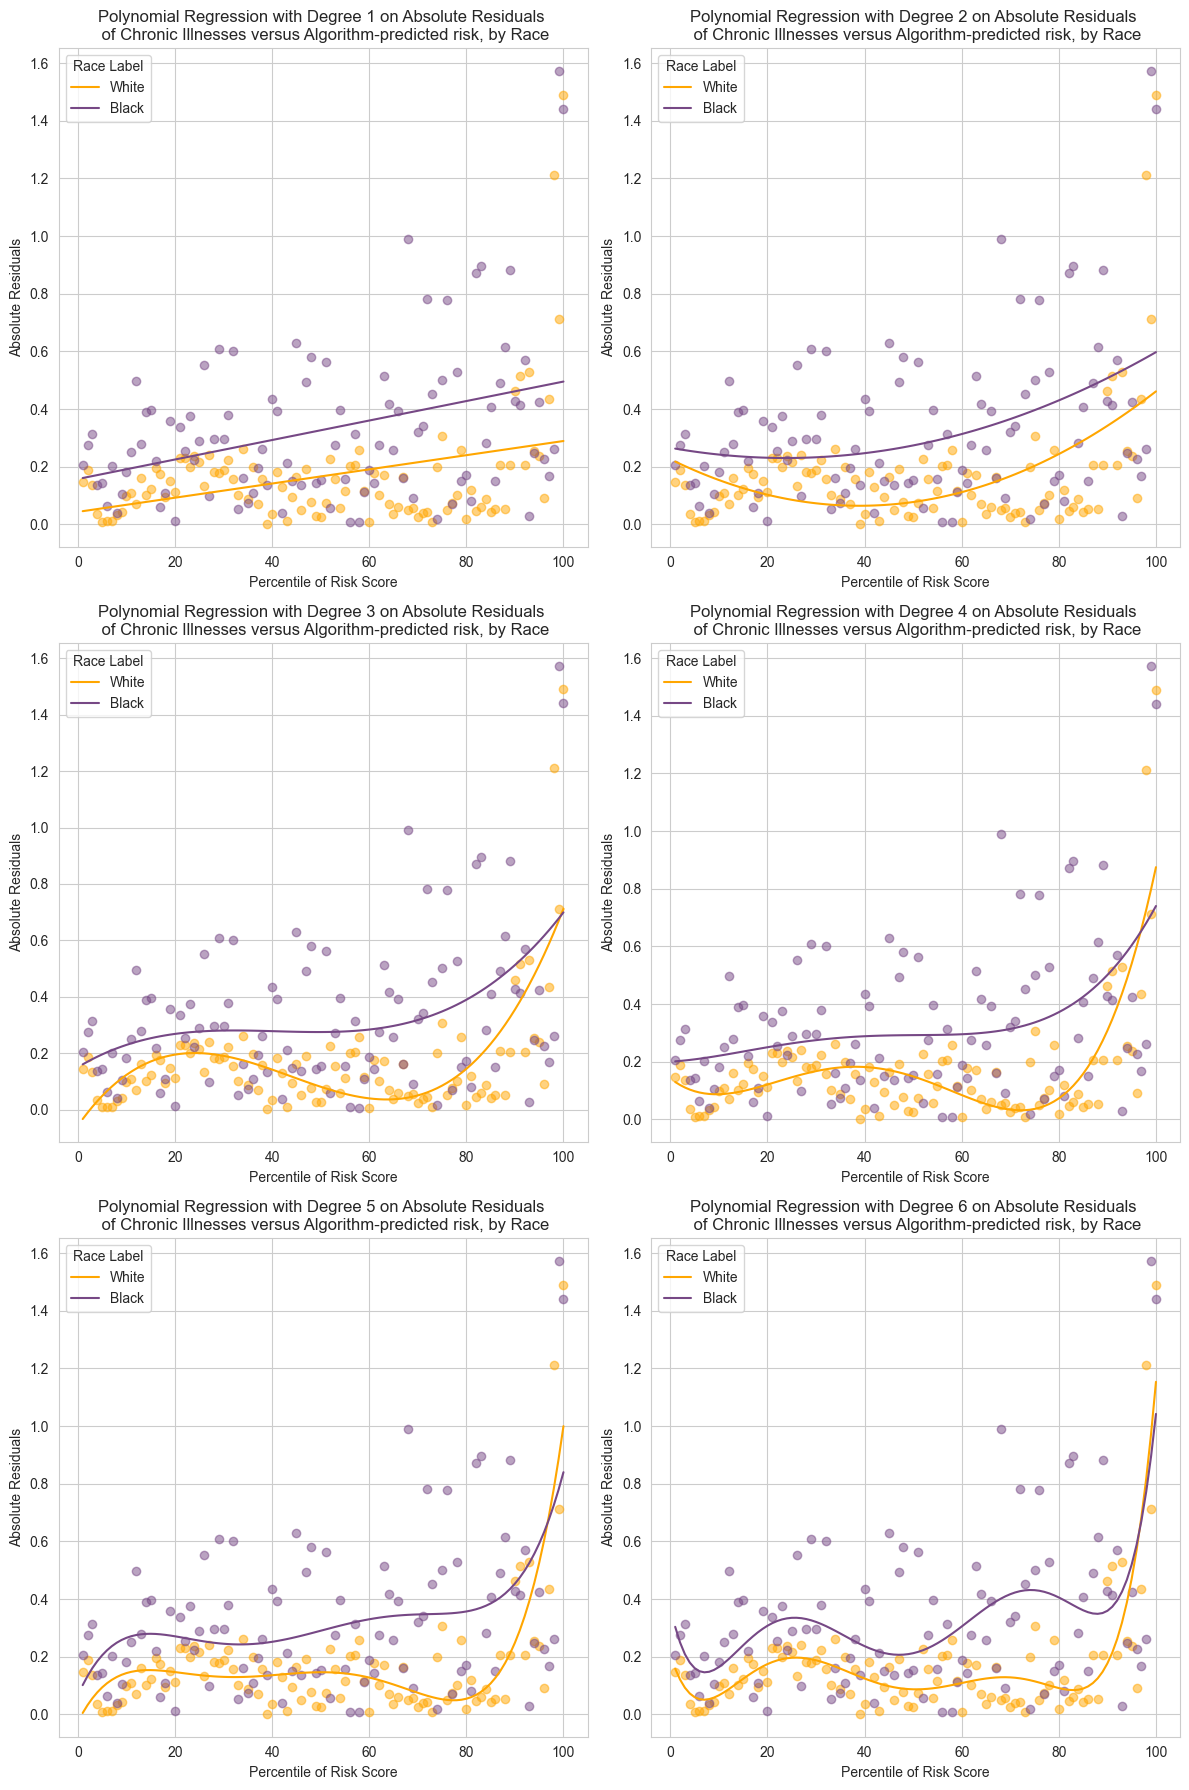

In [12]:
#same approach as above but with absolute residuals
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()
coefficients_absolute_chronic = {}
p_values_absolute_chronic = {}
mse_dict_chronic_abs = {}
deviance_dict_chronic_abs = {}

for i, degree in enumerate(range(1, 7)):
    for race_label in group_label:
        race_int = race_mapping[race_label]
        race_predicted_data = actual_gagne_grouped[actual_gagne_grouped['dem_race_black'] == race_int]
        ax = axes[i]

        #drops residuals of other race
        if race_int == 1:
            residuals = df_results['Black_residuals'].dropna()
        else:
            residuals = df_results['White_residuals'].dropna()

        #absolute residuals
        residuals = abs(residuals)

        #polynomial regression
        percentiles_re = race_predicted_data['risk_score_t_percentile'].values.reshape(-1, 1)
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        v_poly = poly_features.fit_transform(percentiles_re)
        v_poly = sm.add_constant(v_poly)

        model = sm.OLS(residuals, v_poly).fit()

        #stores deviance, coefficients, p-values, and mse
        log_likelihood_current = model.llf
        deviance_current = -2 * log_likelihood_current
        deviance_dict_chronic_abs[(race_label, degree)] = deviance_current

        coefficients = model.params
        p_values = model.pvalues
        coefficients_absolute_chronic[(race_label, degree)] = coefficients
        p_values_absolute_chronic[(race_label, degree)] = p_values
        mse = model.mse_resid
        mse_dict_chronic_abs[(race_label, degree)] = mse

        #plotting   
        x_line = np.linspace(percentiles_re.min(), percentiles_re.max(), 100).reshape(-1, 1)
        x_line_poly = poly_features.transform(x_line)
        x_line_poly = sm.add_constant(x_line_poly)
        y_pred = model.predict(x_line_poly)


        ax.scatter(percentiles_re, residuals, alpha=0.5, color=color_scheme[race_int])
        ax.plot(x_line, y_pred, color=color_scheme[race_int], label=f'{race_label}')

        ax.set_title('Polynomial Regression with Degree {Degree} on Absolute Residuals \n of Chronic Illnesses versus Algorithm-predicted risk, by Race'.format(Degree=degree))
        ax.set_ylabel('Absolute Residuals')
        ax.set_xlabel('Percentile of Risk Score')
        legend = ax.legend()
        legend.set_title('Race Label')

plt.tight_layout()

In [13]:
#prints coefficients, p-values, and mse
for (race_label, degree), coefficients in coefficients_absolute_chronic.items():
  p_values = p_values_absolute_chronic[(race_label, degree)]
  mse = mse_dict_chronic_abs[(race_label, degree)]  
  print(f"Race Label: {race_label}, Degree: {degree}")
  print(f"Coefficients: {coefficients}")
  print(f"P-values: {p_values}")
  print(f"MSE: {mse}")  
  print("-" * 20)  

Race Label: White, Degree: 1
Coefficients: const    0.043344
x1       0.002458
dtype: float64
P-values: const    0.276513
x1       0.000485
dtype: float64
MSE: 0.0386369159541862
--------------------
Race Label: Black, Degree: 1
Coefficients: const    0.157406
x1       0.003379
dtype: float64
P-values: const    0.003202
x1       0.000276
dtype: float64
MSE: 0.06680400011821133
--------------------
Race Label: White, Degree: 2
Coefficients: const    0.226131
x1      -0.008294
x2       0.000106
dtype: float64
P-values: const    0.000088
x1       0.001414
x2       0.000028
dtype: float64
MSE: 0.032547580974006715
--------------------
Race Label: Black, Degree: 2
Coefficients: const    0.265771
x1      -0.002996
x2       0.000063
dtype: float64
P-values: const    0.000980
x1       0.403788
x2       0.068579
dtype: float64
MSE: 0.06521244583572969
--------------------
Race Label: White, Degree: 3
Coefficients: const   -0.056675
x1       0.024494
x2      -0.000701
x3       0.000005
dtype: fl

In [14]:
#prints deviance and change in deviance with respect to degree 1
for (race_label, degree), deviance_current in deviance_dict_chronic_abs.items():
    deviance_degree_1 = deviance_dict_chronic_abs[(race_label, 1)]
    change_in_deviance = deviance_current - deviance_degree_1
    print(f"Race Label: {race_label}, Degree: {degree}")
    print(f"Deviance: {deviance_current}")
    print(f"Change in Deviance with respect to degree 1: {change_in_deviance}")
    print("-" * 20)

Race Label: White, Degree: 1
Deviance: -43.58727285816221
Change in Deviance with respect to degree 1: 0.0
--------------------
Race Label: Black, Degree: 1
Deviance: 11.16820408685848
Change in Deviance with respect to degree 1: 0.0
--------------------
Race Label: White, Degree: 2
Deviance: -61.76343713994012
Change in Deviance with respect to degree 1: -18.176164281777915
--------------------
Race Label: Black, Degree: 2
Deviance: 7.731291770956119
Change in Deviance with respect to degree 1: -3.4369123159023616
--------------------
Race Label: White, Degree: 3
Deviance: -100.47198077051135
Change in Deviance with respect to degree 1: -56.88470791234914
--------------------
Race Label: Black, Degree: 3
Deviance: 5.0434296429185395
Change in Deviance with respect to degree 1: -6.124774443939941
--------------------
Race Label: White, Degree: 4
Deviance: -118.78936129797901
Change in Deviance with respect to degree 1: -75.2020884398168
--------------------
Race Label: Black, Degree: 4

# Mean total expenditure

In [15]:
# Adds epsilon to avoid log(0) - similar to approach Obermeyer
EPSILON = 1.001
df_results['log_cost'] = np.log10(df_results['cost_t'] + EPSILON)

#data manipulation
actual_cost_grouped = df_results.groupby(['risk_score_t_percentile', 'dem_race_black'])['log_cost'].mean().reset_index()
predicted_cost_grouped = df_results.groupby(['risk_score_t_percentile', 'dem_race_black'])['log_cost_t_hat'].mean().reset_index()

#used for plotting
xname = 'Percentile of Algorithm Risk Score'
yname = 'Mean Total Medical Expenditure'
titlename = 'Mean Total Expenditure versus Algorithm-predicted risk, by Race'
color_scheme = ["#ffa600", "#764885"]
linetype_scheme = ['-', '--']
race_mapping = {"White": 0, "Black": 1}

default_in_percentile = 97
additional_screen_percentile = 55
vlocation_threshold = np.log10(40000)

#### Recreation of Obermeyer plot: Mean total expenditure VS algorithm-predicted risk

C:\Users\mana2\AppData\Local\Temp\ipykernel_27132\2458876391.py:15: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=actual_cost_grouped, x='risk_score_t_percentile', y='log_cost', hue='dem_race_black',


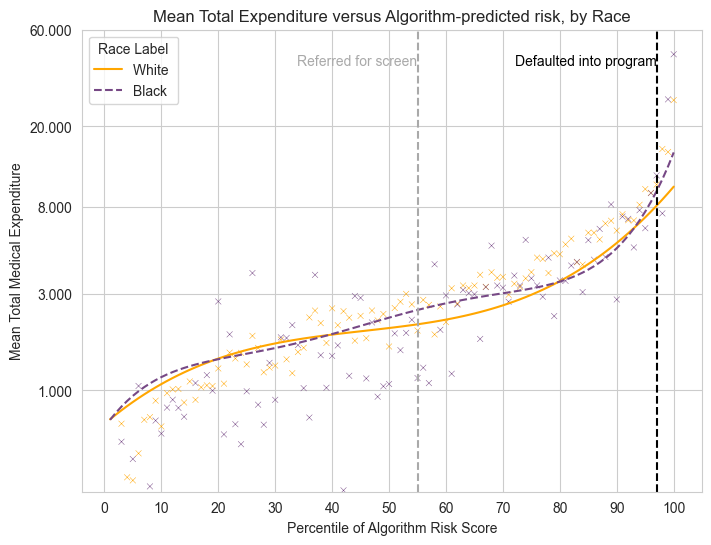

In [16]:
locale.setlocale(locale.LC_ALL, '') 
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

#For converting log values to actual values
brkk_log = []
#values in array same as in Obenmeyer
values = np.array([1000,3000,8000,20000,60000])
for val in values:
    brkk_log.append(np.log10(val))

brkk = np.power(10, brkk_log)
labb =  [locale.format_string('%d', num, grouping=True) for num in brkk]

sns.scatterplot(data=actual_cost_grouped, x='risk_score_t_percentile', y='log_cost', hue='dem_race_black',
                style='dem_race_black', palette=color_scheme, markers=['x'], s=18, alpha=1, legend=False)

#smoothing
for race_label, linestyle in zip(group_label, linetype_scheme):
    race_int = race_mapping[race_label]
    race_predicted_data = predicted_cost_grouped[predicted_cost_grouped['dem_race_black'] == race_int]

    X_smooth = race_predicted_data['risk_score_t_percentile']
    y_smooth = race_predicted_data['log_cost_t_hat']
    if race_int == 1:
        degree = 5
    else:
        degree = 3
    p = np.polyfit(X_smooth, y_smooth, degree)
    y_poly2 = np.polyval(p, X_smooth)

    sns.lineplot(x=X_smooth, y=y_poly2, linestyle=linestyle, color=color_scheme[race_int], label=f'{race_label} ')
    df_results.loc[race_predicted_data.index, f'{race_label}_smoothed_cost_t'] = y_poly2

plt.axvline(x=default_in_percentile, color='black', linestyle='--')
plt.text(default_in_percentile, vlocation_threshold, 'Defaulted into program', color='black', ha='right')
plt.axvline(x=additional_screen_percentile, color='darkgray', linestyle='--')
plt.text(additional_screen_percentile, vlocation_threshold,  'Referred for screen', color='darkgray', ha='right')
plt.xlabel(xname)
plt.ylabel(yname)
plt.title(titlename)
plt.ylim(min(brkk_log) - 0.5, max(brkk_log))
plt.gca().set_xticks(np.arange(0, 101, 10))
plt.yticks(brkk_log, labb)
legend = plt.legend()

legend.set_title('Race Label')



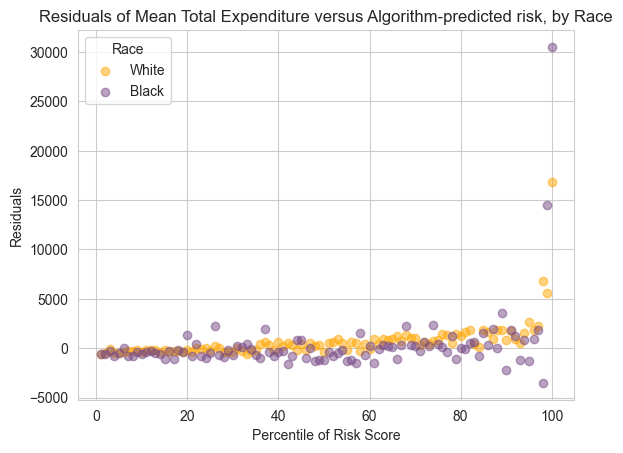

In [17]:
#calculate signed residuals, taking into account log values
for race_label in group_label:
    race_int = race_mapping[race_label]
    race_predicted_data = df_results[df_results['dem_race_black'] == race_int]
    
    if race_int == 1:
        cost_black = df_results['Black_smoothed_cost_t'].dropna()
        cost_black = 10**cost_black
        log_cost = actual_cost_grouped['log_cost']
        cost = 10**log_cost
        residuals = cost - cost_black

    else:
        cost_white = df_results['White_smoothed_cost_t'].dropna()
        cost_white = 10**cost_white
        log_cost = actual_cost_grouped['log_cost']
        cost = 10**log_cost
        residuals = cost - cost_white

    df_results.loc[actual_cost_grouped.index, f'{race_label}_residuals_cost'] = residuals
    plt.scatter(actual_cost_grouped['risk_score_t_percentile'], residuals, alpha=0.5, color = color_scheme[race_int], label = race_label)


plt.title('Residuals of Mean Total Expenditure versus Algorithm-predicted risk, by Race')
plt.xlabel('Percentile of Risk Score')
plt.ylabel('Residuals')

plt.legend(title=groupbycolorname, loc='upper left')
    

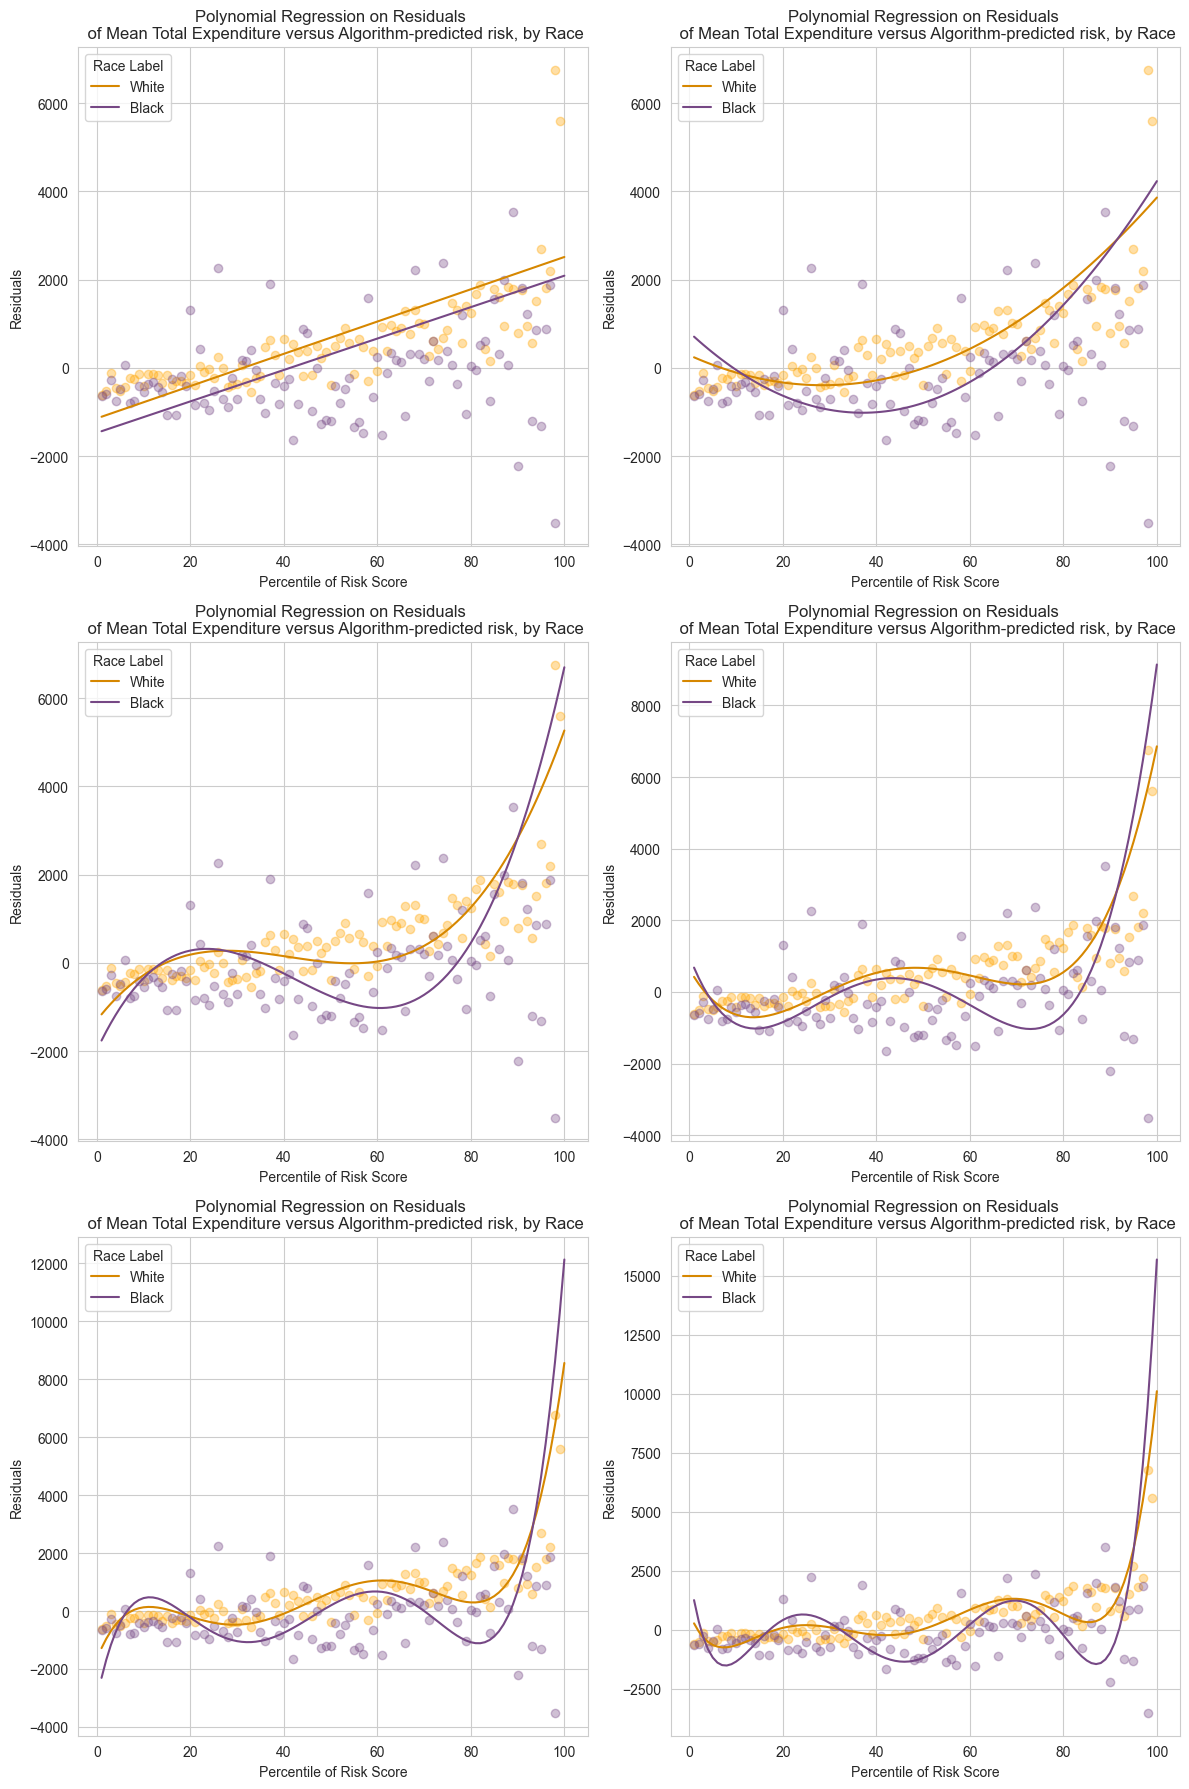

In [18]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()
coefficients_cost_old = {}
p_values_cost_old = {}
mse_dict_cost = {}
deviance_dict_cost = {}

#for better readability, due to close values
color_scheme_dark = ["#d68700", "#764885"]

for i, degree in enumerate(range(1, 7)):
    for race_label in group_label:
        #selecting values for race
        race_int = race_mapping[race_label]
        race_predicted_data = actual_cost_grouped[actual_cost_grouped['dem_race_black'] == race_int]
        ax = axes[i]
        percentiles = race_predicted_data['risk_score_t_percentile']

        #signed residuals
        if race_int == 1:
            residuals = df_results['Black_residuals_cost'].dropna()
            
        else:
            residuals = df_results['White_residuals_cost'].dropna()

        percentiles_re = race_predicted_data['risk_score_t_percentile'].values.reshape(-1, 1)
        #polynomial regression
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        v_poly = poly_features.fit_transform(percentiles_re)
        v_poly = sm.add_constant(v_poly)

        model = sm.OLS(residuals, v_poly).fit()

        #stores deviance, coefficients, p-values, and mse
        log_likelihood_current = model.llf
        deviance_current = -2 * log_likelihood_current
        deviance_dict_cost[(race_label, degree)] = deviance_current

        coefficients = model.params
        p_values = model.pvalues
        coefficients_cost_old[(race_label, degree)] = coefficients
        p_values_cost_old[(race_label, degree)] = p_values
        mse = model.mse_resid
        mse_dict_cost[(race_label, degree)] = mse

        x_line = np.linspace(percentiles_re.min(), percentiles_re.max(), 100).reshape(-1, 1)
        x_line_poly = poly_features.transform(x_line)
        x_line_poly = sm.add_constant(x_line_poly)
        y_pred = model.predict(x_line_poly)
        
        #drops outliers for better visualization
        mask = residuals < 10000

        ax.scatter(percentiles_re[mask], residuals[mask], alpha=0.35, color=color_scheme[race_int])
        ax.plot(x_line, y_pred, color=color_scheme_dark[race_int], label=f'{race_label}')
          
        ax.set_title('Polynomial Regression with Degree {Degree} on Residuals \n of Mean Total Expenditure versus Algorithm-predicted risk, by Race'.format(Degree=degree))
          
        ax.set_title('Polynomial Regression on Residuals \n of Mean Total Expenditure versus Algorithm-predicted risk, by Race')
        ax.set_ylabel('Residuals')
        ax.set_xlabel('Percentile of Risk Score')
        legend = ax.legend()
        legend.set_title('Race Label')



plt.tight_layout()

In [19]:
#prints coefficients, p-values, and mse
for (race_label, degree), coefficients in coefficients_cost_old.items():
  p_values = p_values_cost_old[(race_label, degree)]
  mse = mse_dict_cost[(race_label, degree)]  
  print(f"Race Label: {race_label}, Degree: {degree}")
  print(f"Coefficients: {coefficients}")
  print(f"P-values: {p_values}")
  print(f"MSE: {mse}")  
  print("-" * 20)  

Race Label: White, Degree: 1
Coefficients: const   -1146.560542
x1         36.587970
dtype: float64
P-values: const    9.112473e-04
x1       6.747622e-09
dtype: float64
MSE: 2766298.8110416536
--------------------
Race Label: Black, Degree: 1
Coefficients: const   -1473.846156
x1         35.618110
dtype: float64
P-values: const    0.034313
x1       0.003251
dtype: float64
MSE: 11612052.166752253
--------------------
Race Label: White, Degree: 2
Coefficients: const    284.432181
x1       -47.588072
x2         0.833426
dtype: float64
P-values: const    0.549804
x1       0.030398
x2       0.000119
dtype: float64
MSE: 2397193.129388787
--------------------
Race Label: Black, Degree: 2
Coefficients: const    802.750789
x1       -98.299357
x2         1.325916
dtype: float64
P-values: const    0.425220
x1       0.034406
x2       0.003261
dtype: float64
MSE: 10725364.843584735
--------------------
Race Label: White, Degree: 3
Coefficients: const   -1301.894706
x1        136.326736
x2         -

In [20]:
#prints deviance and change in deviance with respect to degree 1
for (race_label, degree), deviance_current in deviance_dict_cost.items():
    deviance_degree_1 = deviance_dict_cost[(race_label, 1)]
    change_in_deviance = deviance_current - deviance_degree_1
    print(f"Race Label: {race_label}, Degree: {degree}")
    print(f"Deviance: {deviance_current}")
    print(f"Change in Deviance with respect to degree 1: {change_in_deviance}")
    print("-" * 20)

Race Label: White, Degree: 1
Deviance: 1765.0695174486134
Change in Deviance with respect to degree 1: 0.0
--------------------
Race Label: Black, Degree: 1
Deviance: 1908.522845569481
Change in Deviance with respect to degree 1: 0.0
--------------------
Race Label: White, Degree: 2
Deviance: 1749.7226940388243
Change in Deviance with respect to degree 1: -15.346823409789067
--------------------
Race Label: Black, Degree: 2
Deviance: 1899.5539899174248
Change in Deviance with respect to degree 1: -8.968855652056163
--------------------
Race Label: White, Degree: 3
Deviance: 1734.9752414916425
Change in Deviance with respect to degree 1: -30.094275956970932
--------------------
Race Label: Black, Degree: 3
Deviance: 1889.6472965866424
Change in Deviance with respect to degree 1: -18.87554898283861
--------------------
Race Label: White, Degree: 4
Deviance: 1716.194109550928
Change in Deviance with respect to degree 1: -48.87540789768536
--------------------
Race Label: Black, Degree: 4


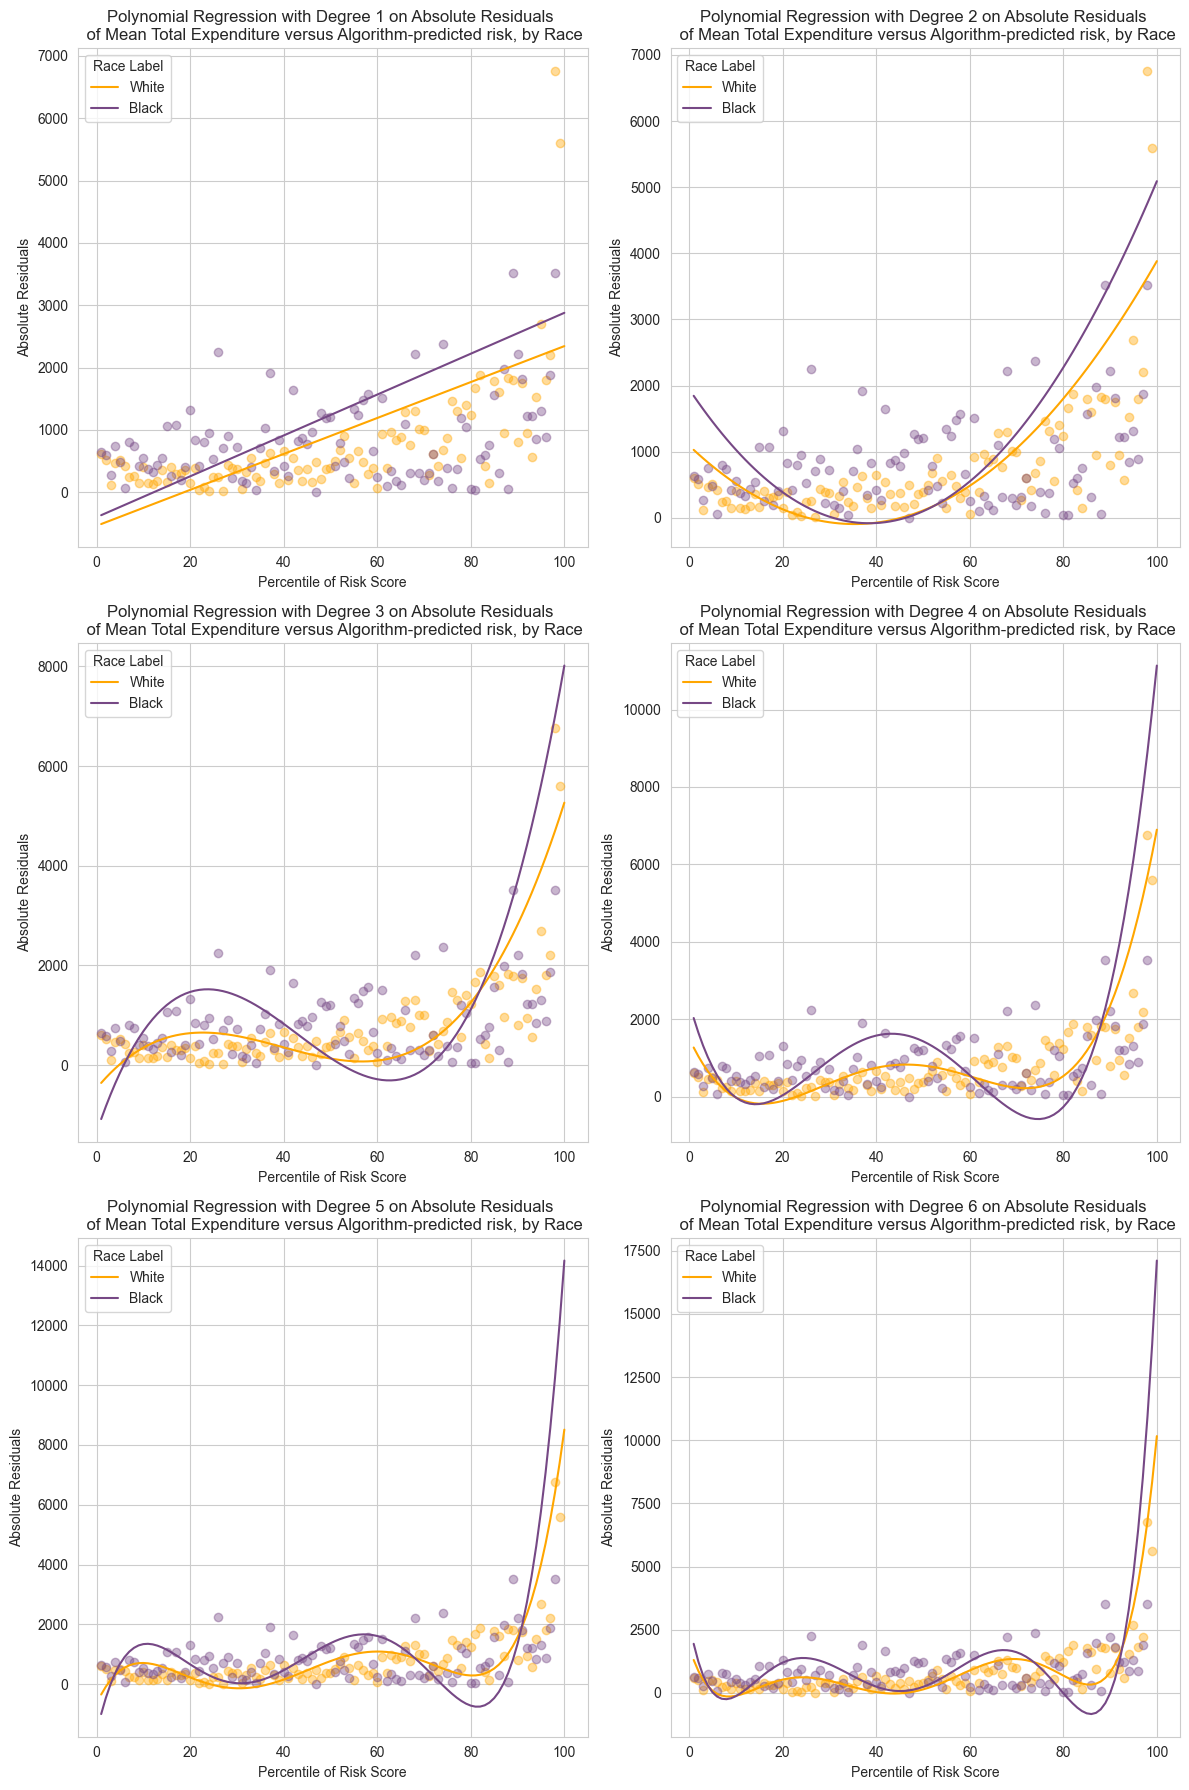

In [21]:
#same approach as above but with absolute residuals
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()
coefficients_cost_old_abs = {}
p_values_cost_old_abs = {}
mse_dict_cost_abs = {}
deviance_dict_cost_abs = {}

for i, degree in enumerate(range(1, 7)):
    for race_label in group_label:
        race_int = race_mapping[race_label]
        race_predicted_data = actual_cost_grouped[actual_cost_grouped['dem_race_black'] == race_int]
        ax = axes[i]
        percentiles = race_predicted_data['risk_score_t_percentile']
        #drops residuals for other race
        if race_int == 1:
            residuals = df_results['Black_residuals_cost'].dropna()
            
        else:
            residuals = df_results['White_residuals_cost'].dropna() 

        #absolute residuals
        residuals = abs(residuals)

        percentiles_re = race_predicted_data['risk_score_t_percentile'].values.reshape(-1, 1)
        #polynomial regression
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        v_poly = poly_features.fit_transform(percentiles_re)
        v_poly = sm.add_constant(v_poly)

        model = sm.OLS(residuals, v_poly).fit()

        #stores deviance, coefficients, p-values, and mse
        log_likelihood_current = model.llf
        deviance_current = -2 * log_likelihood_current
        deviance_dict_cost_abs[(race_label, degree)] = deviance_current
        

        coefficients = model.params
        p_values = model.pvalues
        coefficients_cost_old_abs[(race_label, degree)] = coefficients
        p_values_cost_old_abs[(race_label, degree)] = p_values
        mse = model.mse_resid
        mse_dict_cost_abs[(race_label, degree)] = mse

        x_line = np.linspace(percentiles_re.min(), percentiles_re.max(), 100).reshape(-1, 1)
        x_line_poly = poly_features.transform(x_line)
        x_line_poly = sm.add_constant(x_line_poly)
        y_pred = model.predict(x_line_poly)

        #drops outliers for better visualization
        mask = residuals < 10000
        ax.scatter(percentiles_re[mask], residuals[mask], alpha=0.4, color=color_scheme[race_int])
        ax.plot(x_line, y_pred, color=color_scheme[race_int], label=f'{race_label}')
          
        ax.set_title('Polynomial Regression with Degree {Degree} on Absolute Residuals \n of Mean Total Expenditure versus Algorithm-predicted risk, by Race'.format(Degree=degree))
        ax.set_ylabel('Absolute Residuals')
        ax.set_xlabel('Percentile of Risk Score')
        legend = ax.legend()
        legend.set_title('Race Label')
        



plt.tight_layout()

In [22]:
#prints coefficients, p-values, and mse
for (race_label, degree), coefficients in coefficients_cost_old_abs.items():
    p_values = p_values_cost_old_abs[(race_label, degree)]
    mse = mse_dict_cost_abs[(race_label, degree)]  
    print(f"Race Label: {race_label}, Degree: {degree}")
    print(f"Coefficients: {coefficients}")
    print(f"P-values: {p_values}")
    print(f"MSE: {mse}")  
    print("-" * 20)


Race Label: White, Degree: 1
Coefficients: const   -538.552166
x1        28.824651
dtype: float64
P-values: const    0.116079
x1       0.000003
dtype: float64
MSE: 2841469.468569481
--------------------
Race Label: Black, Degree: 1
Coefficients: const   -400.385111
x1        32.781228
dtype: float64
P-values: const    0.536838
x1       0.003955
dtype: float64
MSE: 10277390.029853826
--------------------
Race Label: White, Degree: 2
Coefficients: const    1094.457092
x1        -67.234717
x2          0.951083
dtype: float64
P-values: const    0.021828
x1       0.002287
x2       0.000012
dtype: float64
MSE: 2352947.1899433257
--------------------
Race Label: Black, Degree: 2
Coefficients: const    1949.358351
x1       -105.438976
x2          1.368517
dtype: float64
P-values: const    0.039510
x1       0.015259
x2       0.001183
dtype: float64
MSE: 9311233.642338559
--------------------
Race Label: White, Degree: 3
Coefficients: const   -467.415668
x1       113.844940
x2        -3.508862
x

In [23]:
#prints deviance and change in deviance with respect to degree 1
for (race_label, degree), deviance_current in deviance_dict_cost_abs.items():
    deviance_degree_1 = deviance_dict_cost_abs[(race_label, 1)]
    change_in_deviance = deviance_current - deviance_degree_1
    print(f"Race Label: {race_label}, Degree: {degree}")
    print(f"Deviance: {deviance_current}")
    print(f"Change in Deviance with respect to degree 1: {change_in_deviance}")
    print("-" * 20)

Race Label: White, Degree: 1
Deviance: 1767.7506253924796
Change in Deviance with respect to degree 1: 0.0
--------------------
Race Label: Black, Degree: 1
Deviance: 1896.3131256701554
Change in Deviance with respect to degree 1: 0.0
--------------------
Race Label: White, Degree: 2
Deviance: 1747.859708266928
Change in Deviance with respect to degree 1: -19.890917125551596
--------------------
Race Label: Black, Degree: 2
Deviance: 1885.4150006632508
Change in Deviance with respect to degree 1: -10.898125006904593
--------------------
Race Label: White, Degree: 3
Deviance: 1733.3085365136278
Change in Deviance with respect to degree 1: -34.44208887885179
--------------------
Race Label: Black, Degree: 3
Deviance: 1868.8292070202397
Change in Deviance with respect to degree 1: -27.483918649915722
--------------------
Race Label: White, Degree: 4
Deviance: 1713.1295642506882
Change in Deviance with respect to degree 1: -54.621061141791415
--------------------
Race Label: Black, Degree:

### Mean Total Expenditure: Polynomial Regression without removed Outliers - for Appendix

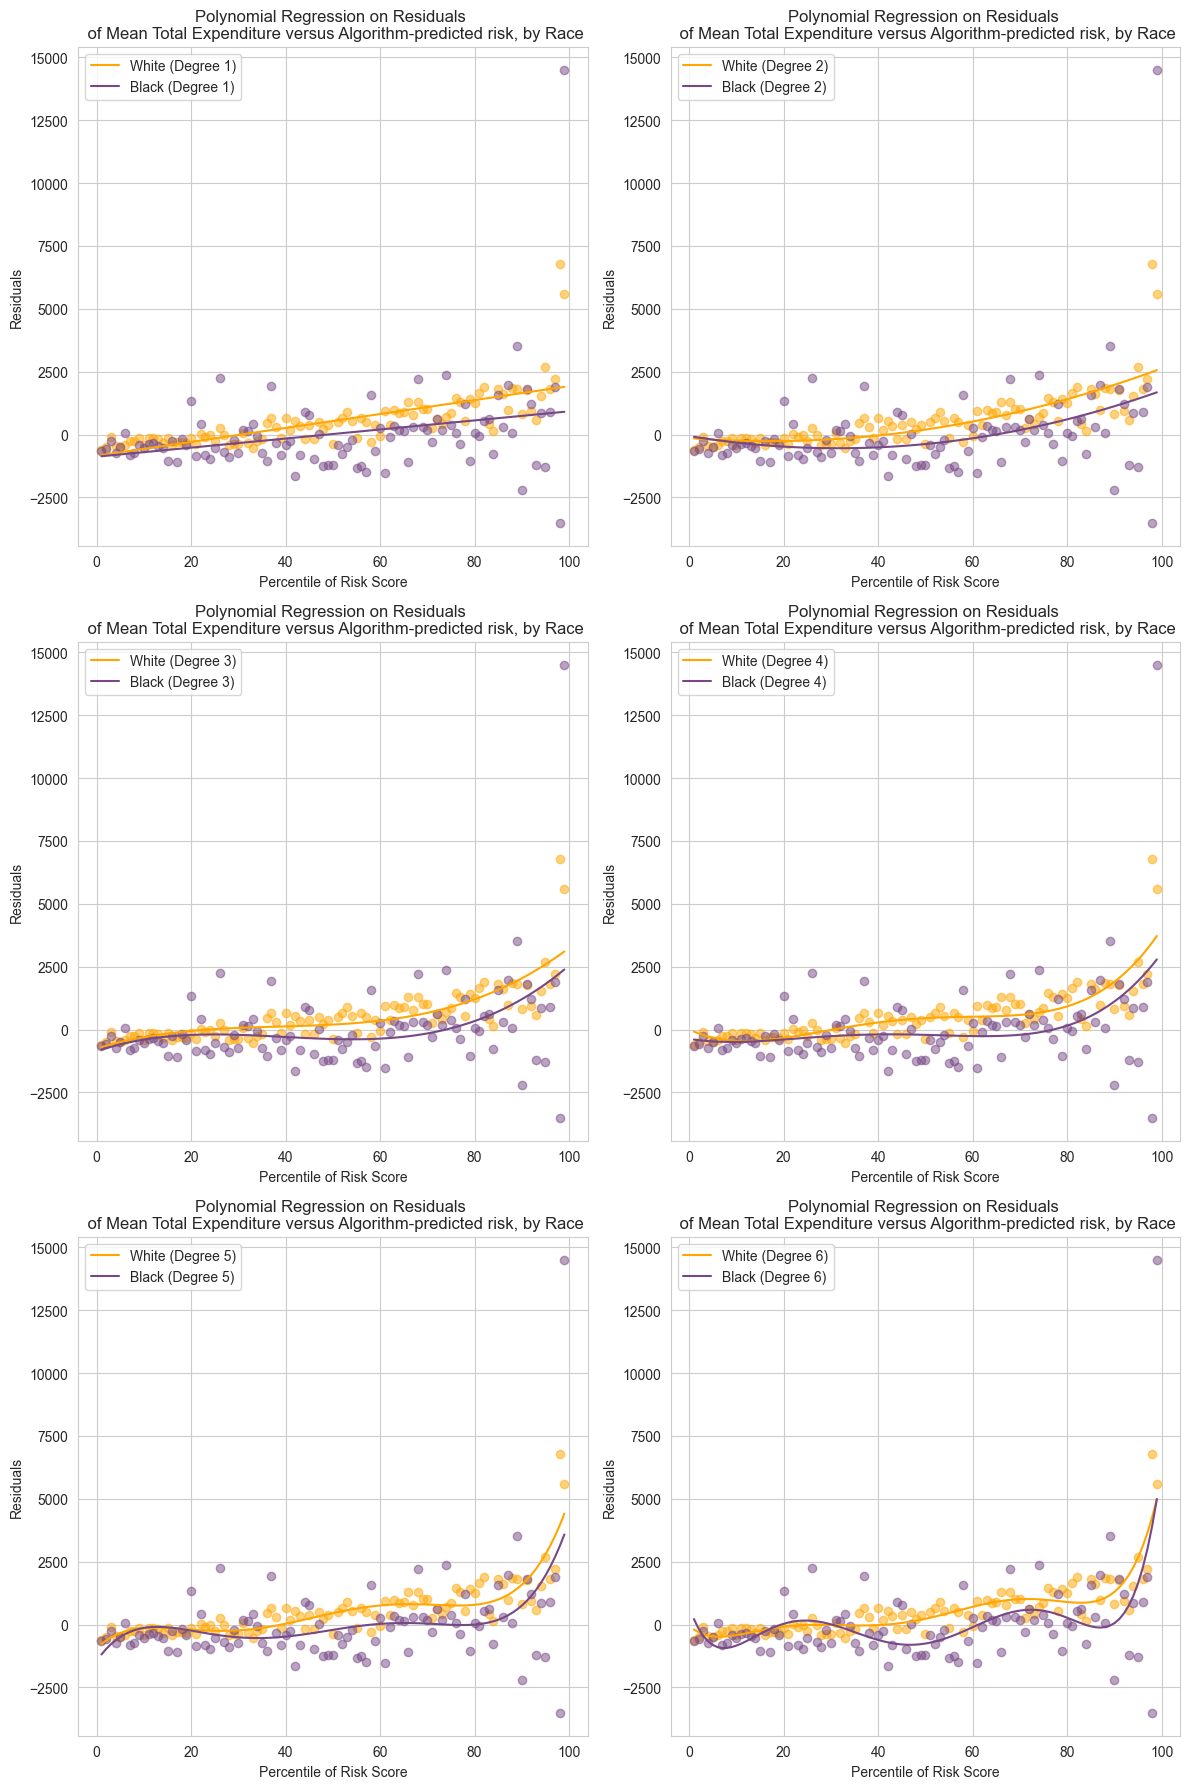

In [24]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()
coefficients_cost = {}
p_values_cost = {}

for i, degree in enumerate(range(1, 7)):
    for race_label in group_label:
        race_int = race_mapping[race_label]
        race_predicted_data = actual_cost_grouped[actual_cost_grouped['dem_race_black'] == race_int]
        ax = axes[i]
        percentiles = race_predicted_data['risk_score_t_percentile']
        
        #signed residuals
        if race_int == 1:
            residuals = df_results['Black_residuals_cost'].dropna()
            mask = residuals <= 15000
            residuals = residuals[mask]
            
        else:
            residuals = df_results['White_residuals_cost'].dropna()
            mask = residuals <= 15000
            residuals = residuals[mask]
            
        mask_reset = mask.reset_index(drop=True)
        percentiles_re = percentiles[mask_reset.values.ravel()].values.reshape(-1, 1)
        

        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        v_poly = poly_features.fit_transform(percentiles_re)

        v_poly = sm.add_constant(v_poly)

        model = sm.OLS(residuals, v_poly).fit()

        coefficients = model.params
        p_values = model.pvalues
        coefficients_cost[(race_label, degree)] = coefficients
        p_values_cost[(race_label, degree)] = p_values

        x_line = np.linspace(percentiles_re.min(), percentiles_re.max(), 100).reshape(-1, 1)
        x_line_poly = poly_features.transform(x_line)
        x_line_poly = sm.add_constant(x_line_poly)
        y_pred = model.predict(x_line_poly)


        ax.scatter(percentiles_re, residuals, alpha=0.5, color=color_scheme[race_int])
        ax.plot(x_line, y_pred, color=color_scheme[race_int], label=f'{race_label} (Degree {degree})')
          
        ax.set_title('Polynomial Regression on Residuals \n of Mean Total Expenditure versus Algorithm-predicted risk, by Race')
        ax.set_ylabel('Residuals')
        ax.set_xlabel('Percentile of Risk Score')
        ax.legend()



plt.tight_layout()

In [25]:
for (race_label, degree), coefficients in coefficients_cost.items():
  p_values = p_values_cost[(race_label, degree)]
  print(f"Race Label: {race_label}, Degree: {degree}")
  print(f"Coefficients: {coefficients}")
  print(f"P-values: {p_values}")
  print("-" * 20)  

Race Label: White, Degree: 1
Coefficients: const   -847.553801
x1        27.706582
dtype: float64
P-values: const    3.242787e-07
x1       2.572474e-17
dtype: float64
--------------------
Race Label: Black, Degree: 1
Coefficients: const   -882.007389
x1        18.038741
dtype: float64
P-values: const    0.014494
x1       0.004198
dtype: float64
--------------------
Race Label: White, Degree: 2
Coefficients: const   -142.939502
x1       -14.151693
x2         0.418583
dtype: float64
P-values: const    0.508976
x1       0.158314
x2       0.000035
dtype: float64
--------------------
Race Label: Black, Degree: 2
Coefficients: const   -60.357876
x1      -30.772121
x2        0.488109
dtype: float64
P-values: const    0.909476
x1       0.211043
x2       0.041968
dtype: float64
--------------------
Race Label: White, Degree: 3
Coefficients: const   -756.612725
x1        57.690129
x2        -1.368468
x3         0.011914
dtype: float64
P-values: const    0.007974
x1       0.018422
x2       0.0159

In [28]:
#prints deviance and change in deviance with respect to degree 1
for (race_label, degree), deviance_current in coefficients_cost.items():
    deviance_degree_1 = deviance_dict_cost_abs[(race_label, 1)]
    change_in_deviance = deviance_current - deviance_degree_1
    print(f"Race Label: {race_label}, Degree: {degree}")
    print(f"Deviance: {deviance_current}")
    print(f"Change in Deviance with respect to degree 1: {change_in_deviance}")
    print("-" * 20)

Race Label: White, Degree: 1
Deviance: const   -847.553801
x1        27.706582
dtype: float64
Change in Deviance with respect to degree 1: const   -2615.304427
x1      -1740.044044
dtype: float64
--------------------
Race Label: Black, Degree: 1
Deviance: const   -882.007389
x1        18.038741
dtype: float64
Change in Deviance with respect to degree 1: const   -2778.320515
x1      -1878.274385
dtype: float64
--------------------
Race Label: White, Degree: 2
Deviance: const   -142.939502
x1       -14.151693
x2         0.418583
dtype: float64
Change in Deviance with respect to degree 1: const   -1910.690127
x1      -1781.902319
x2      -1767.332043
dtype: float64
--------------------
Race Label: Black, Degree: 2
Deviance: const   -60.357876
x1      -30.772121
x2        0.488109
dtype: float64
Change in Deviance with respect to degree 1: const   -1956.671001
x1      -1927.085247
x2      -1895.825017
dtype: float64
--------------------
Race Label: White, Degree: 3
Deviance: const   -756.6

#### Absolute Residuals

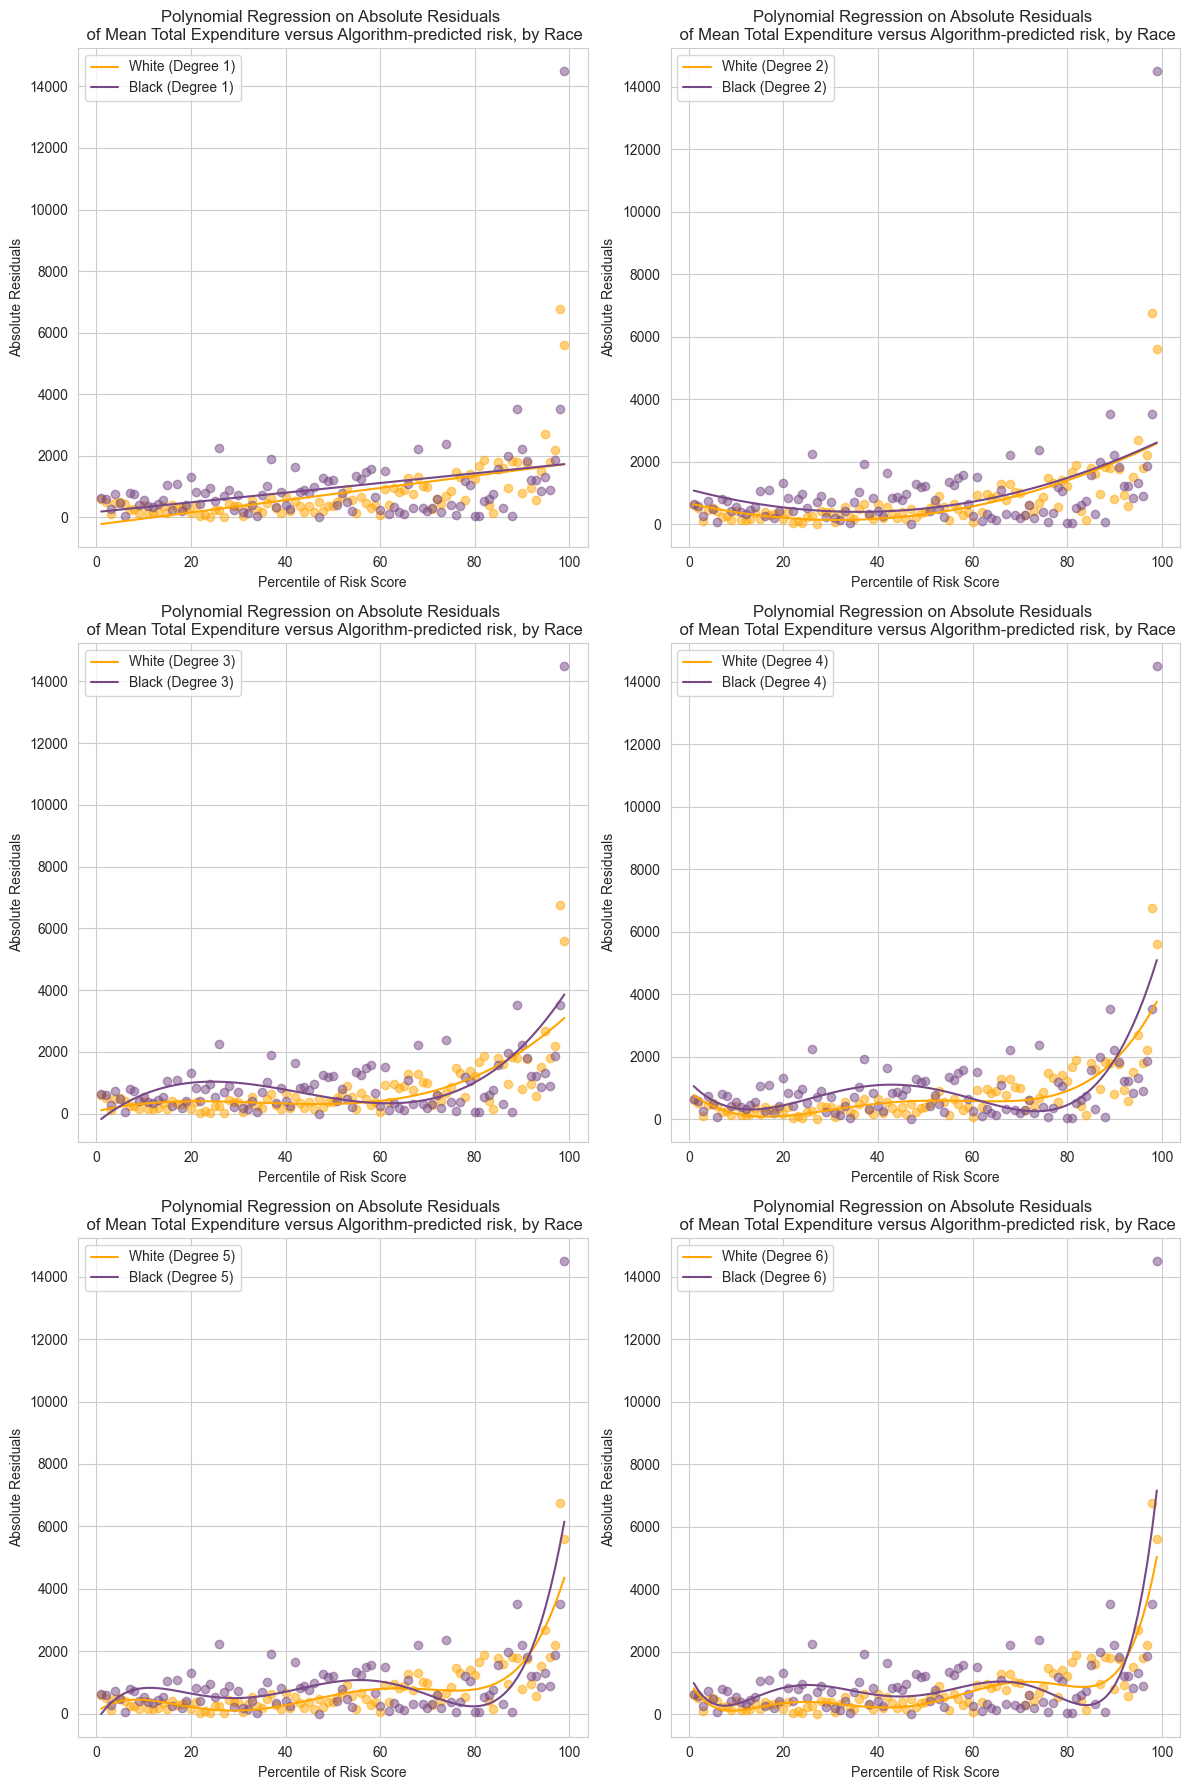

In [26]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()
coefficients_cost_absolute = {}
p_values_cost_absolute = {}

for i, degree in enumerate(range(1, 7)):
    for race_label in group_label:
        race_int = race_mapping[race_label]
        race_predicted_data = actual_cost_grouped[actual_cost_grouped['dem_race_black'] == race_int]
        ax = axes[i]
        percentiles = race_predicted_data['risk_score_t_percentile']

        if race_int == 1:
            residuals = df_results['Black_residuals_cost'].dropna()
            residuals = abs(residuals)  
            mask = residuals <= 15000
            residuals = residuals[mask]
            
        else:
            residuals = df_results['White_residuals_cost'].dropna()
            residuals = abs(residuals)  
            mask = residuals <= 15000
            residuals = residuals[mask]
            
        mask_reset = mask.reset_index(drop=True)
        percentiles_re = percentiles[mask_reset.values.ravel()].values.reshape(-1, 1)
        

        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        v_poly = poly_features.fit_transform(percentiles_re)

        v_poly = sm.add_constant(v_poly)

        model = sm.OLS(residuals, v_poly).fit()

        coefficients = model.params
        p_values = model.pvalues
        coefficients_cost_absolute[(race_label, degree)] = coefficients
        p_values_cost_absolute[(race_label, degree)] = p_values

        x_line = np.linspace(percentiles_re.min(), percentiles_re.max(), 100).reshape(-1, 1)
        x_line_poly = poly_features.transform(x_line)
        x_line_poly = sm.add_constant(x_line_poly)
        y_pred = model.predict(x_line_poly)


        ax.scatter(percentiles_re, residuals, alpha=0.5, color=color_scheme[race_int])
        ax.plot(x_line, y_pred, color=color_scheme[race_int], label=f'{race_label} (Degree {degree})')
          
        ax.set_title('Polynomial Regression on Absolute Residuals \n of Mean Total Expenditure versus Algorithm-predicted risk, by Race')
        ax.set_ylabel('Absolute Residuals')
        ax.set_xlabel('Percentile of Risk Score')
        ax.legend()



plt.tight_layout()

In [27]:
for (race_label, degree), coefficients in coefficients_cost_absolute.items():
  p_values = p_values_cost_absolute[(race_label, degree)]
  print(f"Race Label: {race_label}, Degree: {degree}")
  print(f"Coefficients: {coefficients}")
  print(f"P-values: {p_values}")
  print("-" * 20)  

Race Label: White, Degree: 1
Coefficients: const   -236.040852
x1        19.839166
dtype: float64
P-values: const    1.373415e-01
x1       1.006121e-10
dtype: float64
--------------------
Race Label: Black, Degree: 1
Coefficients: const    175.010231
x1        15.690277
dtype: float64
P-values: const    0.560347
x1       0.003260
dtype: float64
--------------------
Race Label: White, Degree: 2
Coefficients: const    667.805512
x1       -33.854677
x2         0.536938
dtype: float64
P-values: const    1.722029e-03
x1       6.148536e-04
x2       8.545897e-08
dtype: float64
--------------------
Race Label: Black, Degree: 2
Coefficients: const    1114.448487
x1        -40.117936
x2          0.558082
dtype: float64
P-values: const    0.012794
x1       0.050740
x2       0.005496
dtype: float64
--------------------
Race Label: White, Degree: 3
Coefficients: const    77.855087
x1       35.209952
x2       -1.181030
x3        0.011453
dtype: float64
P-values: const    0.772096
x1       0.130712
x

In [29]:
#prints deviance and change in deviance with respect to degree 1
for (race_label, degree), deviance_current in coefficients_cost_absolute.items():
    deviance_degree_1 = deviance_dict_cost_abs[(race_label, 1)]
    change_in_deviance = deviance_current - deviance_degree_1
    print(f"Race Label: {race_label}, Degree: {degree}")
    print(f"Deviance: {deviance_current}")
    print(f"Change in Deviance with respect to degree 1: {change_in_deviance}")
    print("-" * 20)

Race Label: White, Degree: 1
Deviance: const   -236.040852
x1        19.839166
dtype: float64
Change in Deviance with respect to degree 1: const   -2003.791477
x1      -1747.911459
dtype: float64
--------------------
Race Label: Black, Degree: 1
Deviance: const    175.010231
x1        15.690277
dtype: float64
Change in Deviance with respect to degree 1: const   -1721.302895
x1      -1880.622848
dtype: float64
--------------------
Race Label: White, Degree: 2
Deviance: const    667.805512
x1       -33.854677
x2         0.536938
dtype: float64
Change in Deviance with respect to degree 1: const   -1099.945113
x1      -1801.605303
x2      -1767.213687
dtype: float64
--------------------
Race Label: Black, Degree: 2
Deviance: const    1114.448487
x1        -40.117936
x2          0.558082
dtype: float64
Change in Deviance with respect to degree 1: const    -781.864639
x1      -1936.431062
x2      -1895.755044
dtype: float64
--------------------
Race Label: White, Degree: 3
Deviance: const   